## Final Project Submission

Please fill out:
* Student name: Sam Stoltenberg
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: James Irving
* Blog post URL:


In [2]:
import os
import pandas as pd
import pandasql as ps
import numpy as np
import seaborn as sns

store_folder = 'Data'
data = {}  # dictionary of dataframes
total_size = 0  # size of all of the files
for filename in os.listdir(store_folder):
    path = (store_folder+'/'+filename)
    size = os.stat(path).st_size/(1024**2)  # gets the size of the file in MB
    total_size += size
    print("reading", filename, size, 'MB')
    try:
        if path.endswith('tsv.gz'):  # for tsv files
            data[filename[:-7]] = pd.read_csv(path,
                                                delimiter='\t',
                                                low_memory=False)
        else:  # for csv files
            data[filename[:-7]] = pd.read_csv(path,
                                                low_memory=False)
    except UnicodeDecodeError:
        # Changing encoding to reflect utf-8 unknown characters
        if path.endswith('tsv.gz'):
            data[filename[:-7]] = pd.read_csv(path,
                                            delimiter='\t',
                                            low_memory=False,
                                            encoding='windows-1252')
        else:
            data[filename[:-7]] = pd.read_csv(path,
                                            low_memory=False,
                                            encoding='windows-1252')
print('Done loading %s MB' % total_size)

reading imdb.name.basics.tsv.gz 190.70305347442627 MB
reading imdb.title.akas.tsv.gz 189.05681037902832 MB
reading imdb.title.basics.tsv.gz 119.10677146911621 MB
reading imdb.title.crew.tsv.gz 47.09960460662842 MB
reading imdb.title.episode.tsv.gz 26.076172828674316 MB
reading imdb.title.principals.tsv.gz 314.29254722595215 MB
reading imdb.title.ratings.tsv.gz 4.99261474609375 MB
Done loading 891.3275747299194 MB


In [3]:
data['scraped_money'] = pd.read_csv('scraped_data/budget_ratings.csv', index_col=0)

In [4]:

    ['titleId', 'ordering', 'title', 'region', 'language', 'types',
       'attributes', 'isOriginalTitle']  # columns
    name_basics = data['imdb.name.basics']  # saving df to a variable for pysql to access

    ['titleId', 'ordering', 'title', 'region', 'language', 'types',
        'attributes', 'isOriginalTitle']
    title_akas = data['imdb.title.akas']

    ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'endYear', 'runtimeMinutes', 'genres']
    title_basics = data['imdb.title.basics']

    ['tconst', 'directors', 'writers']
    title_crew = data['imdb.title.crew']
    
    ['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber']
    title_episode = data['imdb.title.episode']
    
    ['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']
    title_principals = data['imdb.title.principals']
    
    ['tconst', 'averageRating', 'numVotes']
    title_ratings = data['imdb.title.ratings']

    ['tconst', 'budget', 'ww_gross', 'rating']
    scraped_money = data['scraped_money']

In [5]:

scraped_money = scraped_money.transpose().reset_index().rename(columns={'index':'tconst'})

In [6]:
df = scraped_money

ratings = ['G', 'PG', 'PG-13', 'R']
df['rating'] = df['rating'].map(lambda x: np.NaN if x not in ratings else x)
df['budget'] = df['budget'].map(lambda x: np.NaN if x in[None, 0, '0'] else x)
df['gross'] = df['gross'].map(lambda x: np.NaN if x in[None, 0, '0'] else x)
df['ww_gross'] = df['ww_gross'].map(lambda x: np.NaN if x in[None, 0] else x)
df

,tconst,budget,gross,ww_gross,rating
0,tt2200832,NaN,NaN,NaN,NaN
1,tt2200860,NaN,NaN,1.92477e+06,NaN
2,tt2200908,NaN,NaN,105367,NaN
3,tt2200926,NaN,NaN,5784,NaN
4,tt2200955,NaN,NaN,NaN,NaN
...,...,...,...,...,...
55425,tt7225386,NaN,NaN,1.03234e+07,NaN
55426,tt7225648,NaN,NaN,168615,NaN
55427,tt7225942,NaN,NaN,NaN,NaN
55428,tt7227044,75000,NaN,NaN,NaN


In [7]:
df = df.dropna()
df['budget'] = df['budget'].astype('int64')
df['ww_gross'] = df['ww_gross'].astype('int64')
df['gross'] = df['gross'].astype('int64')
df

,tconst,budget,gross,ww_gross,rating
48,tt2203939,40000000,83911193,196710396,PG-13
67,tt2205401,5000000,17390770,17534314,R
73,tt2205591,100000,71737,71737,PG
92,tt2207006,10000000,110904,110904,PG-13
121,tt2209418,3000000,8114627,20994648,R
...,...,...,...,...,...
55100,tt7131622,90000000,142502728,374343626,R
55120,tt7134096,50000000,5437971,5989583,R
55128,tt7137380,9000000,1533324,5580940,R
55130,tt7137846,6000000,46840590,51411620,PG-13


<AxesSubplot:xlabel='budget', ylabel='gross'>

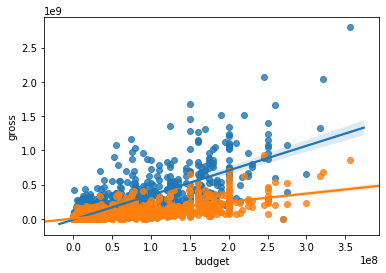

In [8]:
# Do foreign markets make more money then domestic markets?
import matplotlib.pyplot as plt
new_df = df.copy(deep=True)[0:100]
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.regplot("budget", "ww_gross", data=df, ax=ax)
sns.regplot("budget", "gross", data=df, ax=ax)

#ax.legend()
#sns.lmplot(data=df, x='gross', y='ww_gross', hue='budget')

(array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]),
 array([0.  , 0.75, 1.5 , 2.25, 3.  ]),
 <a list of 4 BarContainer objects>)

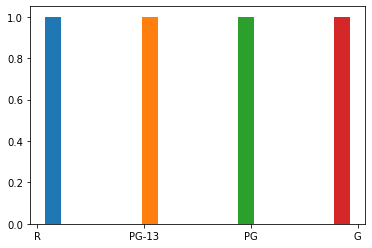

In [9]:
# g = sns.FacetGrid(df, col="rating", height=4, aspect=1)
# g.map(sns.regplot, "budget", "ww_gross")

dicta = df['rating'].value_counts().to_dict()
plt.hist(dicta, bins=4)
# build soccer plot (stacked bar plot)


In [12]:
# take df(scraped_money) and add a column with the % difference of budget-> ww_gross

def compare(budget, gross):
    net = gross - budget
    return net/budget

df['perc'] = compare(df['budget'], df['ww_gross'])
df.sort_values(by='perc', ascending=False)


,tconst,budget,gross,ww_gross,rating,perc
40759,tt1675434,500000,10198820,426588510,R,852.177020
1633,tt2309260,100000,22764410,42964410,R,428.644100
24279,tt1716772,500000,36000,88823111,R,176.646222
52915,tt6523720,100000,6235,13837294,PG-13,137.372940
4108,tt2473794,200000,3958500,22179785,R,109.898925
...,...,...,...,...,...,...
9750,tt4414438,18000000,7162,7162,R,-0.999602
32632,tt0762138,2500000,663,663,R,-0.999735
13785,tt5143890,18000000,3259,3259,R,-0.999819
21601,tt3789946,800000,120,120,PG,-0.999850


In [11]:
q1 = """
SELECT * FROM title_basics
LIMIT 20
"""

In [40]:
called_df = ps.sqldf(q1, locals())
called_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
5,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short
6,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport"
7,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short"
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
9,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short"


In [52]:
# Top genre list from Max
genre_list = ['Thriller',  'Animation',  'Sci-Fi',  'Mystery',  'Music',  'Adventure',  'Fantasy',  'Comedy']
def fix_genre(genres):
    new_genres = []
    genres = genres.split(',')
    # print('ORIGINAL', genres)
    for g in genres:
        if g in genre_list:
            # print('SPOTTED', g)
            new_genres.append(g)
    # print('NEW', new_genres, '\n')
    return new_genres
new_df = called_df.copy(deep=True)
new_df['genres'] = new_df['genres'].apply(lambda x: fix_genre(x))

new_df['genres'] = new_df['genres'].map(lambda x: np.NaN if not x else x)
new_df.dropna()

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Animation', 'Short']
SPOTTED Animation
NEW ['Animation'] 

ORIGINAL ['Animation', 'Comedy', 'Romance']
SPOTTED Animation
SPOTTED Comedy
NEW ['Animation', 'Comedy'] 

ORIGINAL ['Animation', 'Short']
SPOTTED Animation
NEW ['Animation'] 

ORIGINAL ['Comedy', 'Short']
SPOTTED Comedy
NEW ['Comedy'] 

ORIGINAL ['Short']
NEW [] 

ORIGINAL ['Short', 'Sport']
NEW [] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Romance']
NEW [] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Action', 'Documentary', 'Short']
NEW [] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Comedy', 'Short']
SPOTTED Comedy
NEW ['Comedy'] 

ORIGINAL ['Animation', 'Short']
SPOTTED Animation
NEW ['Animation'] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Documentary', 'Short']
NEW [] 

ORIGINAL ['Short']
NEW [] 

ORIGINAL ['Comedy', 'Short']
SPOTTED Comedy
NEW ['Comedy'] 

ORIGINAL ['Documentary'

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,[Animation]
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"[Animation, Comedy]"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,[Animation]
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,[Comedy]
13,tt0000014,short,The Waterer Watered,L'arroseur arrosé,0,1895,\N,1,[Comedy]
14,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,\N,2,[Animation]
18,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,[Comedy]


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,[Animation]
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"[Animation, Comedy]"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,[Animation]
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,[Comedy]
13,tt0000014,short,The Waterer Watered,L'arroseur arrosé,0,1895,\N,1,[Comedy]
14,tt0000015,short,Autour d'une cabine,Autour d'une cabine,0,1894,\N,2,[Animation]
18,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,\N,\N,[Comedy]


In [ ]:
    q1 = """
SELECT tconst FROM title_ratings
JOIN title_basics
USING(tconst)
WHERE startYear > 2000
"""
    qlist = ''
    x = 0
    df = ps.sqldf(q1, locals())
    for i in df['tconst']:
        x+=1
        qlist += str(i+',')
    
    qlist += '\b'
    print(x)
    with open('qlist.txt', 'w') as f:
        f.write(qlist)